In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import collections
import os
import datetime
import shap
import math
from scipy.stats import entropy
from sklearn.metrics import classification_report

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_v2_behavior()

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

from tqdm import tqdm

from IPython.display import Markdown, display

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
#Global Variables
RANDOM_SEED = 42
max_features = 20000
maxlen = 80                        # cut texts after this number of words (among top max_features most common words)
batch_size = 32
EPOCHS = 3
q, c, p, b, k, initial_seed_size, initial_seed, j, S_indices, U_indices, train_indices, model_theta = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [14]:
def load_data():
    print('Loading data...')
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, seed=RANDOM_SEED)
    print(len(x_train), 'train sequences')
    print(len(x_test), 'test sequences')

    print('Pad sequences (samples x time)')
    x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
    x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)

    return x_train, y_train, x_test, y_test

def get_lstm_model():
    print('Build model...')
    model_lstm = Sequential()
    model_lstm.add(Embedding(max_features, 128))
    model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model_lstm.add(Dense(2, activation='softmax'))

    model_lstm.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model_lstm

def init_workflow(x_train):
    global q, c, p, b, k, initial_seed_size, initial_seed, j, S_indices, U_indices, model_theta, train_indices
    np.random.seed(RANDOM_SEED)
    p = 2
    train_indices = [i for i in range(len(x_train))]
    initial_seed_size = int(len(x_train) * 0.005)
    b = initial_seed_size
    k = 2 * initial_seed_size
    initial_seed = np.random.choice(train_indices, size=initial_seed_size, replace=False)
    j = 1
    S_indices = initial_seed
    U_indices = list(set(train_indices) - set(S_indices))

def train_model_lstm(model_lstm, x_train, y_train):
    print('Train...')
    model_lstm.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=EPOCHS,
              validation_data=(x_test, y_test))
    score, acc = model_lstm.evaluate(x_test, y_test,
                                batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)

    return model_lstm


def compute_cosine_similarity(term_dict_1, term_dict_2):
    cosine_sim = 0
    for index in term_dict_1.keys():
        if(index in term_dict_2):
            cosine_sim += term_dict_1[index] * term_dict_2[index]
    values_term_1 = sum([v**2 for k, v in term_dict_1.items()])
    values_term_2 = sum([v**2 for k, v in term_dict_2.items()])

    cosine_sim /= ( math.sqrt(values_term_1) * math.sqrt(values_term_2) )

    return cosine_sim

def compute_fidelity(model_theta, test_samples_i):
    
    x_subset = x_test[test_samples_i]
    TOP_FEATURE_PCT = 0.6
    TOP_FEATURES_LEN = int(len(x_subset[0]) * TOP_FEATURE_PCT)
    
    print(f'{len(x_subset)=} {TOP_FEATURES_LEN=}')
    pred_orig = np.argmax(model_theta.predict(x_subset), axis=1)
    explainer = shap.DeepExplainer(model_theta, x_subset)
    shap_values_labelled = explainer.shap_values(x_subset)
    
    pred_class_shap_values = []
    x_new_subset = np.copy(x_subset)
    for i in range(len(shap_values_labelled[0])):
#         pred_class_shap_values.append(shap_values_labelled[pred_orig[i]][i])
        
        sort_index = np.argsort(-shap_values_labelled[pred_orig[i]][i])
        top_features_index = sort_index[:TOP_FEATURES_LEN]
        mask = np.ones(len(x_subset[0]), dtype=bool)
        mask[top_features_index] = False
        x_new_subset[i, mask] = 0
    
    
#     for i in range(len(pred_class_shap_values)):
#         print(pred_class_shap_values[i])
#         sort_index = np.argsort(-pred_class_shap_values[i])
#         print(sort_index)
#         top_features_index = sort_index[:TOP_FEATURES_LEN]
#         print(top_features_index)
#         print('orig x_subset')
#         print(x_new_subset[i])
#         mask = np.ones(len(x_subset[0]), dtype=bool)
#         mask[top_features_index] = False
#         x_new_subset[i, mask] = 0
#         print('masked')
#         print(x_new_subset[i])
#         break
    pred_masked = np.argmax(model_theta.predict(x_new_subset), axis=1)
    
    return np.sum(pred_orig == pred_masked)

In [ ]:
%%time

global q, c, p, b, k, initial_seed_size, initial_seed, j, S_indices, U_indices, model_theta, train_indices
init_workflow()

while(j <= p):
    print(f'==========Active Learning Iteration {j}/{p}==========')
    x_train_subset = x_train[S_indices]
    y_train_subset = y_train[S_indices]

    print('Training Prediction Model')
    model_theta = get_lstm_model()
    model_theta = train_model_lstm(model_theta, x_train_subset, y_train_subset)

    train_preds = np.argmax(model_theta.predict(x_train_subset), axis=1)

    print('Generating Classification Report')
    y_pred = np.argmax(model_theta.predict(x_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    if(j == p):
        break

    print('Training Explainer Model on Labelled Set')
    explainer = shap.DeepExplainer(model_theta, x_train_subset)

    print(f'Computing Shap values for labelled instances - {len(x_train_subset)}')
    shap_values_labelled = explainer.shap_values(x_train_subset)

    print('Predicting unlabelled instances')
    s_x = np.ndarray((len(U_indices), 3))
    preds = model_theta.predict(x_train[U_indices])
    # s_x[:, 0] = np.amax(preds, axis=1)
    s_x[:, 0] = entropy(np.array(preds), base=2,axis=1)
    s_x[:, 1] = U_indices
    s_x[:, 2] = np.argmax(preds, axis=1)

    sort_index = np.argsort(-s_x[:, 0])
    s_x = s_x[sort_index]
    c_indxs = list(map(int, s_x[:k, 1]))

    pred_y_dict = dict(zip(s_x[:k, 1], s_x[:k, 2]))

    print('Training Explainer Model on Unlabelled Candidate Set')
    explainer = shap.DeepExplainer(model_theta, x_train[c_indxs])

    print(f'Computing Shap values for unlabelled candidate set instances - {len(x_train[c_indxs])}')
    shap_values_unlabelled = explainer.shap_values(x_train[c_indxs])

    print('Computing Similarities')
    xu_kld = np.ndarray((len(c_indxs), 2))
    for i, index_xu in enumerate(tqdm(c_indxs)):
        term_dict_U = dict(zip(x_train[int(index_xu)], shap_values_unlabelled[int(pred_y_dict[int(index_xu)])][i]))
        for q, index_x in enumerate(S_indices):
            term_dict_S = dict(zip(x_train[int(index_x)], shap_values_labelled[y_train[int(index_x)]][q]))
            xu_kld[i][0] += compute_cosine_similarity(term_dict_S, term_dict_U)
        xu_kld[i][0] /= len(S_indices)
        xu_kld[i][1] = index_xu

    sort_index = np.argsort(xu_kld[:, 0])
    xu_kld = xu_kld[sort_index]                                             #least similar first; get such top k samples
    delta_S = xu_kld[:b, 1]
    print(f'Adding {len(delta_S)} samples to labelled set.')
    S_indices = np.append(S_indices, list(map(int, delta_S)))
    print(f'Total samples in labelled set {len(S_indices)}')
    print(f'Removing {len(delta_S)} samples from unlabelled set')
    U_indices = list(set(train_indices) - set(S_indices))
    print(f'Total samples in unlabelled set {len(U_indices)}')
    j += 1

In [ ]:
test_indices = [i for i in range(len(x_test))]

global model_theta

np.random.seed(RANDOM_SEED)
test_samples_i = np.random.choice(test_indices, size=100, replace=False)
fidelity = compute_fidelity(model_theta, test_samples_i)
print(f'Fidelity {fidelity}')

In [15]:
%%time

global q, c, p, b, k, initial_seed_size, initial_seed, j, S_indices, U_indices, model_theta, train_indices
x_train, y_train, x_test, y_test = load_data()
init_workflow(x_train)

while(j <= p):
    printmd(f'==========Active Learning Iteration {j}/{p}==========')
    x_train_subset = x_train[S_indices]
    y_train_subset = y_train[S_indices]
    
    print('Training Prediction Model')
    model_theta = get_lstm_model()
    model_theta = train_model_lstm(model_theta, x_train_subset, y_train_subset)
    
    if(j == p):
        break
    
    print(f'Selecting random {initial_seed_size} samples')
    delta_S = np.random.choice(U_indices, size=initial_seed_size, replace=False)
    
    print(f'Adding {len(delta_S)} samples to labelled set.')
    S_indices = np.append(S_indices, list(map(int, delta_S)))
    print(f'Total samples in labelled set {len(S_indices)}')
    
    print(f'Removing {len(delta_S)} samples from unlabelled set')
    U_indices = list(set(train_indices) - set(S_indices))
    print(f'Total samples in unlabelled set {len(U_indices)}')

    U_indices = list(set(train_indices) - set(S_indices))
    j += 1

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


==========Active Learning Iteration 1/2==========

Training Prediction Model
Build model...
Train...
Train on 125 samples, validate on 25000 samples
Epoch 1/3
125/125 [==============================] - 16s 129ms/sample - loss: 0.6944 - acc: 0.5040 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/3
125/125 [==============================] - 17s 135ms/sample - loss: 0.6783 - acc: 0.5600 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 3/3
125/125 [==============================] - 17s 137ms/sample - loss: 0.6600 - acc: 0.5600 - val_loss: 0.6993 - val_acc: 0.5000
Test score: 0.6993396546936035
Test accuracy: 0.5
Selecting random 125 samples
Adding 125 samples to labelled set.
Total samples in labelled set 250
Removing 125 samples from unlabelled set
Total samples in unlabelled set 24750


==========Active Learning Iteration 2/2==========

Training Prediction Model
Build model...
Train...
Train on 250 samples, validate on 25000 samples
Epoch 1/3
250/250 [==============================] - 19s 74ms/sample - loss: 0.6946 - acc: 0.4760 - val_loss: 0.6923 - val_acc: 0.5021
Epoch 2/3
250/250 [==============================] - 18s 72ms/sample - loss: 0.6789 - acc: 0.7000 - val_loss: 0.6898 - val_acc: 0.5302
Epoch 3/3
250/250 [==============================] - 18s 72ms/sample - loss: 0.6344 - acc: 0.8680 - val_loss: 0.6702 - val_acc: 0.6078
Test score: 0.6701873497962951
Test accuracy: 0.60776
Wall time: 2min 24s


In [34]:
test_indices = [i for i in range(len(x_test))]

global model_theta

np.random.seed(RANDOM_SEED)
test_samples_i = np.random.choice(test_indices, size=100, replace=False)
fidelity = compute_fidelity(model_theta, test_samples_i)
print(f'Fidelity {fidelity}')

len(x_subset)=100 TOP_FEATURES_LEN=48
Fidelity 96


In [ ]:
%%time

global q, c, p, b, k, initial_seed_size, initial_seed, j, S_indices, U_indices, model_theta, train_indices
init_workflow()

while(j <= p):
    printmd(f'==========Active Learning Iteration {j}/{p}==========')
    x_train_subset = x_train[S_indices]
    y_train_subset = y_train[S_indices]
    
    print('Training Prediction Model')
    model_theta = get_lstm_model()
    model_theta = train_model_lstm(model_theta, x_train_subset, y_train_subset)
    
    if(j == p):
        break
    
    print('Predicting unlabelled instances and computing uncertainty by least confidence')
    s_x = np.ndarray((len(U_indices), 2))
    s_x[:, 0] = 1-np.amax(model_theta.predict(x_train[U_indices]), axis=1)
    s_x[:, 1] = U_indices
    sort_index = np.argsort(s_x[:, 0])
    s_x = s_x[-sort_index]   #larger the (1-model_top_pred) difference, lower the confidence of the model in that prediction, get such top k samples
    delta_S = s_x[:k, 1]

    print(f'Adding {len(delta_S)} samples to labelled set.')
    S_indices = np.append(S_indices, list(map(int, delta_S)))
    print(f'Total samples in labelled set {len(S_indices)}')
    
    print(f'Removing {len(delta_S)} samples from unlabelled set')
    U_indices = list(set(train_indices) - set(S_indices))
    print(f'Total samples in unlabelled set {len(U_indices)}')
    
    j += 1

In [ ]:
test_indices = [i for i in range(len(x_test))]

global model_theta

np.random.seed(RANDOM_SEED)
test_samples_i = np.random.choice(test_indices, size=100, replace=False)
fidelity = compute_fidelity(model_theta, test_samples_i)
print(f'Fidelity {fidelity}')

In [ ]:
%%time

global q, c, p, b, k, initial_seed_size, initial_seed, j, S_indices, U_indices, model_theta, train_indices
init_workflow()

while(j <= p):
    printmd(f'==========Active Learning Iteration {j}/{p}==========')
    x_train_subset = x_train[S_indices]
    y_train_subset = y_train[S_indices]
    
    print('Training Prediction Model')
    model_theta = get_lstm_model()
    model_theta = train_model_lstm(model_theta, x_train_subset, y_train_subset)
    
    if(j == p):
        break
    
    print('Predicting unlabelled instances and computing uncertainty by smallest margin')
    s_x = np.ndarray((len(U_indices), 2))
    pred = model_theta.predict(x_train[U_indices])
    s_x[:, 0] = abs(pred[:, 0] - pred[:, 1])
    s_x[:, 1] = U_indices
    sort_index = np.argsort(s_x[:, 0])
    s_x = s_x[sort_index]   #smallest difference (margin) means model is struggling to differentiate between the two classes; take such top k samples
    delta_S = s_x[:k, 1]

    print(f'Adding {len(delta_S)} samples to labelled set.')
    S_indices = np.append(S_indices, list(map(int, delta_S)))
    print(f'Total samples in labelled set {len(S_indices)}')
    
    print(f'Removing {len(delta_S)} samples from unlabelled set')
    U_indices = list(set(train_indices) - set(S_indices))
    print(f'Total samples in unlabelled set {len(U_indices)}')
    
    j += 1

In [23]:
test_indices = [i for i in range(len(x_test))]

global model_theta

np.random.seed(RANDOM_SEED)
test_samples_i = np.random.choice(test_indices, size=100, replace=False)
fidelity = compute_fidelity(model_theta, test_samples_i)
print(f'Fidelity {fidelity}')

a=5 b=6


In [1]:
from scipy.stats import entropy

In [10]:
prob = [0.55, 0.45]
entropy(prob, axis=0, base=2)

0.9927744539878083

In [12]:
lstm = get_lstm_model()

Build model...


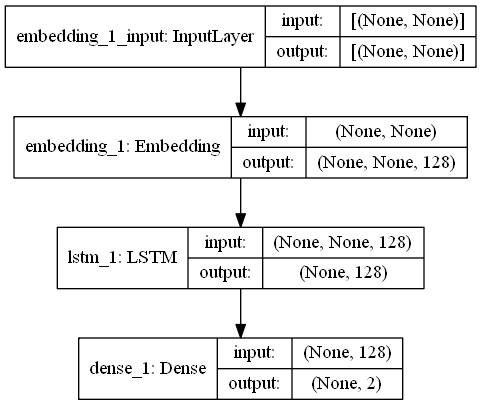

In [13]:
tf.keras.utils.plot_model(lstm, show_shapes=True)

In [15]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
